# Feature Engineering

In the following cells we will tackle first some pre-processing steps and then we will follow with some feature engineering steps:


1. Categorical variables: remove unnecessary variables
2. Missing values
3. Non-Gaussian distributed variables
4. Encode categorical variables
5. Standarize the values of the variables to the same range

It is very important that every element in our code that include some randomness in it includes a **setting seed**. This way, we can obtain reproducibility between our research and our development code. 

In [384]:
# Import basic libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

import warnings
warnings.simplefilter(action='ignore')

In [385]:
# load dataset
data = pd.read_csv('train.csv')
print(data.shape)
data.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Categorical variables: remove unnecessary variables

The data analysis proved that *PassengerId, Name, Ticket and Cabin* do not provide useful information. Therefore we drop this variables from the dataset.

In [386]:
drop_var = ['PassengerId', 'Name', 'Ticket', 'Cabin']
data = data.drop(drop_var, axis=1)
print(data.shape)

(891, 8)


Before beginning with the rest of steps defined above, let's start separating the dataset into training and testing partitions. This is important for the future model because we don't want it to infer information from the training into the testing partition.

In [387]:
# Let's separate into train and test set
# Important to set the seed !!

X_train, X_test, y_train, y_test = train_test_split(data,
                                                    data['Survived'],
                                                    test_size=0.2,
                                                    # we are setting the seed here:
                                                    random_state=0)  

X_train.shape, X_test.shape

((712, 8), (179, 8))

### Missing Values

#### Categorical variables
 

In [388]:
# make a list of categorical variables:

cat_var_na= [var for var in data.columns if data[var].dtypes == 'O' 
          and data[var].isnull().sum() > 0]

data[cat_var_na].isnull().mean()

Embarked    0.002245
dtype: float64

In [389]:
# replace missing values with new label: "Missing"

X_train[cat_var_na] = X_train[cat_var_na].fillna('Missing')
X_test[cat_var_na] = X_test[cat_var_na].fillna('Missing')

# check there are no missing values
display(X_train[cat_var_na].isnull().mean())
display(X_test[cat_var_na].isnull().mean())

Embarked    0.0
dtype: float64

Embarked    0.0
dtype: float64

#### Numerical variables

We will engineer missing values in numerical values, following two steps:

1. add a binary missing value indicator variable
2. replace the missing values in the original variable with the mode

In [390]:
# make a list with the numerical variables that contain missing values
num_var_na = [
    var for var in data.columns
    if X_train[var].isnull().sum() > 0 and X_train[var].dtypes != 'O'
]

# print percentage of missing values per variable
X_train[num_var_na].isnull().mean()

Age    0.198034
dtype: float64

In [391]:
X_test[num_var_na].isnull().mean()

Age    0.201117
dtype: float64

In [392]:
for var in num_var_na:
    
    # Compute the mode using the train set
    mode_val = X_train[var].mode()[0]
    
    # add binary missing indicator in the two partitions
    X_train[var+'_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var+'_na'] = np.where(X_test[var].isnull(), 1, 0)
    
    # replace missing values with the training mode
    X_train[var] = X_train[var].fillna(mode_val)
    X_test[var] = X_test[var].fillna(mode_val)
    
# Check there are no missing values in both partitions

X_train[num_var_na].isnull().sum()


Age    0
dtype: int64

In [393]:
# Check that test set does not contain null values...
# X_test[num_var_na].isnull().mean()

In [394]:
# Try again!
# X_test['Age'] = X_test['Age'].fillna(mode_val)

In [395]:
X_test['Age'].isnull().sum()

0

### Non-Gaussian Distributed Variables

In the data analysis notebook there were two numerical variables that are not normally distributed: *Age* and *Fare*.

*Age* can be approximated to a normal distribution using a log transformation. 

However, *Fare* variable does not admit a log transformation, as it contains 0 and negative values. Even other transformation such as squaring the variable do not work either. We will limit ourselves to transform the *Fare* variable to a strictly null or positive variable.

In [396]:
# Age variable transformation
X_train['Age'] = np.log(X_train['Age'])
X_test['Age'] = np.log(X_test['Age'])

In [397]:
# Fare variable transformation
X_train['Fare'] = abs(X_train['Fare'])
X_test['Fare'] = abs(X_test['Fare'])

In [398]:
# check the train set does not contain missing values in the engineered variables
[var for var in ['Age', 'Fare'] if X_train[var].isnull().sum() > 0]

[]

In [399]:
# check the test set does not contain missing values in the engineered variables
[vars for vars in ['Age', 'Fare'] if X_test[var].isnull().sum() > 0]

[]

In [400]:
X_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_na
140,0,3,female,3.178054,0,2,15.2458,C,1
439,0,2,male,3.433987,0,0,10.5000,S,0
817,0,2,male,3.433987,1,1,37.0042,C,0
378,0,3,male,2.995732,0,0,4.0125,C,0
491,0,3,male,3.044522,0,0,7.2500,S,0


In [401]:
X_test.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_na
495,0,3,male,3.178054,0,0,14.4583,C,1
648,0,3,male,3.178054,0,0,7.5500,S,1
278,0,3,male,1.945910,4,1,29.1250,Q,0
31,1,1,female,3.178054,1,0,146.5208,C,1
255,1,3,female,3.367296,0,2,15.2458,C,0


### Encode categorical Variables

In this section, the categorical variables will be encoded to turn the strings into numbers. The idea is to capture the monotonic relationship between the label and the target.

To achieve that, the discrete values of the categorical variables will have a lower or higher numerical value depending on how they lower or grow the likelihood of surviving. 

In [402]:
def transform_cat(train, test, var, target):
    
    # order the categories in a variable from that with the lowest
    # surviving mean, to that with the highest
    ordered_labels = train.groupby([var])[target].mean().sort_values().index
    
    # create a dictionary of ordered categories
    ordinal_label = {k:i for i, k in enumerate(ordered_labels, 0)}
    
    # the dictionary replaces the categorical strings by integers
    train[var] = train[var].map(ordinal_label)
    test[var] = test[var].map(ordinal_label)

In [403]:
# list of categorical variables

cat_var = [var for var in X_train.columns if X_train[var].dtypes == 'O']

for var in cat_var:
    transform_cat(X_train, X_test, var, 'Survived')

In [404]:
# Check na in training set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

In [405]:
# Check na in test set
[var for var in X_test.columns if X_test[var].isnull().sum() > 0]

[]

We can check if there is a monotonic relationship between our encoded categorical variables and the target variable.

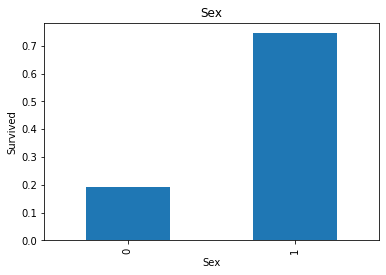

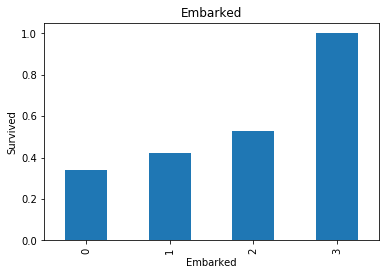

In [408]:
def analyse_vars(df, var):
    
    # function plots mean survival per encoded category
    
    df = df.copy()
    df.groupby(var)['Survived'].mean().plot.bar()
    plt.title(var)
    plt.ylabel('Survived')
    plt.show()
    
for var in cat_var:
    analyse_vars(X_train, var)

The plots show there is a monotonic relationship.

### Feature scaling

Linear models need the features to be scaled or normalised. In this case, we will scale the features so they are all between the same minimum and maximum values. To do that we make use of Scikit-Learn.

In [409]:
all_var = [var for var in X_train.columns if var != 'Survived']

all_var

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Age_na']

In [410]:
# Instance the scaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(X_train[all_var])

# Transform the partitions
X_train[all_var] = scaler.transform(X_train[all_var])
X_test[all_var] = scaler.transform(X_test[all_var])

In [411]:
X_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_na
140,0,1.0,1.0,0.748255,0.000,0.333333,0.029758,0.666667,1.0
439,0,0.5,0.0,0.801769,0.000,0.000000,0.020495,0.000000,0.0
817,0,0.5,0.0,0.801769,0.125,0.166667,0.072227,0.666667,0.0
378,0,1.0,0.0,0.710132,0.000,0.000000,0.007832,0.666667,0.0
491,0,1.0,0.0,0.720334,0.000,0.000000,0.014151,0.000000,0.0


In [412]:
# Save the train and test sets
X_train.to_csv('xtrain.csv', index=False)
X_test.to_csv('xtest.csv', index=False)